<a href="https://colab.research.google.com/github/chetannitk/BeerDataScienceAssignment/blob/master/notebooks/05-sklearn-k-mean-clustering-to-find-similar-beer-drinkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
    <h1> Beer Data Science Assignment <br/></h1>
    K-mean clustering to find similar group of beer drinkers.
</div>


In [1]:
from IPython.display import HTML
import pandas as pd
import os
import numpy as np
from datetime import datetime
import wordcloud
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

BASE_PATH = "../"
INPUT_DATA_PATH = os.path.join(BASE_PATH, "data/raw/BeerDataScienceProject.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [2]:
## Upload BeerDataScienceProject.csv file from local system.
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data/BeerDataScienceProject.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!ls -lrt /tmp

total 405172
drwx------ 2 root root      4096 Jun  1 17:08 tmpz00gqf1l
srw------- 1 root root         0 Jun  1 17:08 drivefs_ipc.0
srw------- 1 root root         0 Jun  1 17:08 drivefs_ipc.0_shell
-rw-r--r-- 1 root root 414885425 Jun  1 17:08 BeerDataScienceProject.csv


In [0]:
import io
df_beer_raw = pd.read_csv('/tmp/BeerDataScienceProject.csv', encoding="ISO-8859-1")

In [5]:
df_beer_raw.shape

(528870, 13)

In [6]:
df_beer_raw.dtypes

beer_ABV              float64
beer_beerId             int64
beer_brewerId           int64
beer_name              object
beer_style             object
review_appearance     float64
review_palette        float64
review_overall        float64
review_taste          float64
review_profileName     object
review_aroma          float64
review_text            object
review_time             int64
dtype: object

### Data Cleaning
```In the below cell we can see that there are some columns where data is missing. 
   We need to remove those data points from our data set.
```

In [7]:
df_beer_raw.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [0]:
df_beer = df_beer_raw.dropna()

In [9]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508358 non-null  float64
 1   beer_beerId         508358 non-null  int64  
 2   beer_brewerId       508358 non-null  int64  
 3   beer_name           508358 non-null  object 
 4   beer_style          508358 non-null  object 
 5   review_appearance   508358 non-null  float64
 6   review_palette      508358 non-null  float64
 7   review_overall      508358 non-null  float64
 8   review_taste        508358 non-null  float64
 9   review_profileName  508358 non-null  object 
 10  review_aroma        508358 non-null  float64
 11  review_text         508358 non-null  object 
 12  review_time         508358 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 54.3+ MB


In [0]:
df_beer = df_beer.reset_index()
df_beer['id'] = df_beer.index

## Data Changes in Raw and Clean dataset

In [11]:
print("Raw data size: ", df_beer_raw.shape[0])
print("Clean data size: ", df_beer.shape[0])
print("Data points difference: ", df_beer_raw.shape[0]-df_beer.shape[0])

Raw data size:  528870
Clean data size:  508358
Data points difference:  20512


### Describe the categorical features

In [12]:
df_beer.describe(include=[np.object])

,beer_name,beer_style,review_profileName,review_text
count,508358,508358,508358,508358
unique,14028,104,22563,508007
top,Sierra Nevada Celebration Ale,American IPA,northyorksammy,#NAME?
freq,2998,42092,1732,90


### Describe the numerical features

In [13]:
df_beer.describe(include=[np.number])

,index,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time,id
count,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,5.083580e+05,508358.000000
mean,263669.490377,7.017400,21824.120840,2534.273207,3.872676,3.768993,3.840805,3.775327,3.827646,1.226175e+09,254178.500000
std,152590.091973,2.204528,22124.969107,5237.843825,0.601764,0.682355,0.706408,0.665586,0.715121,7.530843e+07,146750.458409
min,0.000000,0.010000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08,0.000000
25%,131284.250000,5.300000,1673.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.177202e+09,127089.250000
50%,263756.500000,6.500000,13850.000000,392.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.241503e+09,254178.500000
75%,395689.750000,8.500000,40418.000000,1315.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.289073e+09,381267.750000
max,528796.000000,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09,508357.000000


In [0]:
NUMERICAL_ATTRIBUTE = ['beer_ABV', 'review_appearance', 'review_palette', 
                       'review_overall', 'review_taste', 'review_aroma', 'review_time']
CATEGORICAL_ATTRIBUTE = ['beer_name', 'beer_style', 'review_profileName', 'review_text']

In [15]:
df_beer.sample(4)

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,id
265045,274634,4.7,2249,68,In-Heat Wheat,Hefeweizen,4.0,3.0,4.0,3.0,rajendra82,3.0,"Poured out of the 12 oz. bottle, into a proper...",1143437434,265045
421480,437594,6.0,710,197,Fischer Tradition Amber,Euro Dark Lager,3.5,3.0,4.0,2.5,flagmantho,3.5,Poured from 22 oz swing-top bottle into a pint...,1252341047,421480
407174,422224,5.8,226,73,Great Lakes Edmund Fitzgerald Porter,American Porter,4.0,4.5,4.5,4.0,yankeeheel,4.5,Pours a beautiful deep dark mahogany with a we...,1068155892,407174
355609,368950,4.9,1693,22,U Blond Pilsner,Euro Pale Lager,3.0,3.0,3.5,3.0,allergictomacros,3.0,"Clear gold with a weak, brittle head. Soft lem...",1243898308,355609


<div class="alert alert-info">
Convert the review timestamp to datetime format
</div>

In [0]:
df_beer['d_review_time'] = df_beer.review_time.apply(lambda t: datetime.fromtimestamp(t))

In [0]:
df_beer['d_review_time_year'] = df_beer['d_review_time'].dt.year
df_beer['d_review_time_month'] = df_beer['d_review_time'].dt.month

<div class="alert alert-success">
Q7) How do find similar beer drinkers by using written reviews only?   
</div>

In [18]:
!pip install tensorflow_text

     |████████████████████████████████| 3.0MB 9.0MB/s 


In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
tf.executing_eagerly()

True

In [0]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")

In [0]:
train = df_beer.review_text.tolist()
list_train = [train[i:i+100] for i in range(0,len(train),100)]

## The below cell creates embedding vector for review-text data.

In [22]:
from tqdm import tqdm
data = []
for d in tqdm(list_train):
    data.extend(embed(d).numpy())

100%|██████████| 5084/5084 [00:23<00:00, 220.75it/s]


## Optimal number of k in K-Means

In [0]:
from sklearn.cluster import KMeans

distortions = []
for i in tqdm(range(1, 21)):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data)
    distortions.append(km.inertia_)


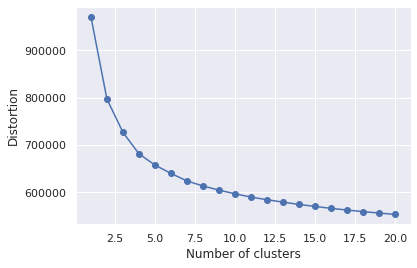

In [25]:
# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## Above graph shows that elbow point lies at k=10

In [0]:
from sklearn.cluster import KMeans

k=10
km = KMeans(
    n_clusters=k, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_pred = km.fit_predict(data)

In [28]:
len(y_pred)

508358

In [29]:
df_beer.shape

(508358, 18)

In [0]:
df_beer['cluster_group'] = y_pred

In [31]:
df_beer.cluster_group.value_counts()

4    73974
7    64167
5    62305
8    58982
1    54292
2    45656
6    45310
0    43930
3    43050
9    16692
Name: cluster_group, dtype: int64

## Below Cell will club all beer_name in cluster 0

In [34]:
print(set(df_beer[df_beer.cluster_group==0]['beer_name'].tolist()))

{'Leeuw Pilsener', 'ESB Amber Ale', 'Crown Brewery Stannington Stout', 'Samuel Adams Utopias', 'Steelback Tiverton Dark Lager', 'Full Suspension Pale Ale', 'Le Secret', 'Plutonium Pilsner', 'Harveys Porter', 'Reserve Wheat Ale', 'White Birch Wrigian', 'Ten Penny Ale Reserve', 'Trappist Pale Ale', 'Pigs Fly Pilsner', 'Curly Horse IPA', 'Hofbräu Premium Lager', 'Zötler Korbinian Dunkel', 'Oude Tart With Sour Cherries', 'Santo Viejo', 'Green Bullet (9th Anniversary)', 'La Clef Des Champs', 'Saison Rue', 'Sierra Nevada Glissade Golden Bock', "Ridin' Dirty", 'Best Of Beer Camp: Weizenbock - Beer Camp #37', 'Steam Engine Lager', 'Scarface Stout', 'The Wanderer', 'Russian Roulette', 'Dog Bite High Gravity Lager', 'Acoustic Amber Ale', 'Belgh Brasse Taïga', 'Le Cheval Blanc Rousse', '"Requisite" Imperialistic Stout', 'Pike Pale Ale', 'St. Paul Triple', 'Samuel Adams Chocolate Bock', 'Vanilla Bourbon Stout', 'Oktoberfest Marzen', "Cantillon Pinot D'Aunis", 'Double Nut Brown', 'Windansea Wheat H